In [1]:
# Import the FEMSystem Class from directory above
import sys
sys.path.append('..')

# Remaining Imports
import jax.numpy as jnp
import skfem as fem
from jaxopt import LBFGS
import jax

In [2]:
import platform
print(f"Platform (should NOT be login node like della-gpu but rather something like della-gXXX): {platform.node()}")

Platform (should NOT be login node like della-gpu but rather something like della-gXXX): della-gpu.princeton.edu


In [3]:
import numpy.typing as npt

import skfem as fem
from skfem.models.poisson import laplace
import jax
import jax.numpy as jnp
import numpy as np

import matplotlib.pyplot as plt
from skfem.visuals.matplotlib import plot
from jax.experimental import sparse
from scipy.spatial import KDTree
from scipy.sparse.linalg import inv

class FEMSystem:

    # Mesh, Element, Basis
    mesh:fem.Mesh = None 
    element:fem.AbstractBasis = None 
    intorder:int = 1
    basis:fem.Basis = None

    # Size of Problem
    elements:int = 0
    quad_per_element:int = 0
    dofs:int = 0

    # Boundary Information
    boundary_condition = 0
    all_dofs = None
    boundary_dofs = None
    interior_dofs = None

    # Weights
    weights = []

    # Interpolation Matrices
    phi_val = None
    phi_grad = None

    # Miscellanous
    dofmap = None
    node_coords_global = None
    coords_q_T = None
    X_ref = None
    W_ref = None
    flip_map = None

    # Constructor - Preprocess Basis
    def __init__(self,mesh,element,intorder,boundary_condition=0):

        # First set mesh, element, intorder and basis
        self.mesh = mesh
        self.element = element
        self.intorder = intorder
        self.basis = fem.CellBasis(mesh, element, intorder=intorder)

        # Step 1: Get boundary information
        self.boundary_condition = boundary_condition
        self.all_dofs = jnp.arange(self.basis.N)
        self.dofs = len(self.all_dofs)
        self.boundary_dofs = self.basis.get_dofs().flatten() # Empty call automatically gets boundary DOFs
        self.interior_dofs = jnp.setdiff1d(self.all_dofs, self.boundary_dofs)

        # Step 2: Get Weights
        weights = jnp.array(self.basis.dx) # Only for quadrature points, not necessarily the nodes
        elements,quad_per_element = weights.shape[0],weights.shape[1]
        self.weights,self.elements,self.quad_per_element = weights,elements,quad_per_element

        # Step 3: Get Interpolation Matrices, phi_val and phi_grad
        X_ref,W_ref = self.basis.quadrature
        n_local_dofs = element.doflocs.shape[0] # 3 for Triangle
        val_list = []
        grad_list = []
        # Loop over local nodes to get basis functions
        for i in range(n_local_dofs):
            dfield = element.gbasis(self.basis.mapping, X_ref, i)[0]
            val_list.append(dfield.value) # (elements,quadratures), value of ith basis function, at quadrature point, in this element
            grad_list.append(dfield.grad) # (dimensions,elements,quadratures), value of the derivative in a direction, of the ith basis function, at quadrature point, in this element
        phi_val = jnp.array(jnp.stack(val_list)).transpose(1, 2, 0) # eth index is interpolation matrix for element e
        phi_grad = jnp.array(jnp.stack(grad_list)).transpose(2, 1, 3, 0) #eth index, array at dth index, is interpolation matrix for element e 
        self.phi_val,self.phi_grad = phi_val,phi_grad

        # Step 4: Get Miscellanous Things
        self.dof_map = self.basis.element_dofs.T # (elements, dofs per element) matrix, maps to a global dof index        
        self.node_coords_global = jnp.array(mesh.doflocs.T)
        # self.dof_map = jnp.ascontiguousarray(self.basis.element_dofs.T.astype(jnp.int32))
        x_quad = self._interpolate_values(self.node_coords_global)
        self.coords_q_T = x_quad.transpose(2, 0, 1) # Cache This
        self.doflocs = self.basis.doflocs # arrays of x,y and z coordinates of the ith DOF
        self.X_ref,self.W_ref = X_ref,W_ref

        # Step 5: Get Flipping Mapping
        self.flip_map = self._generate_flip_mapping()

    
    def _generate_flip_mapping(self,axis=0):
        coords = self.doflocs
        flipped_coords = self.doflocs.copy()
        flipped_coords[axis,:] *= -1

        # Do the Nearest Neighbor Search
        tree = KDTree(flipped_coords.T)

        distances, indices = tree.query(coords.T, k=1)

        return indices
    
    '''
    Arguments:
    - u_global: array of values at degrees of freedom. 
    '''
    def _interpolate_values(self,u_global):
        u_local_arr = u_global[self.dof_map] # for every element, get the actual dof value at the nodes in the element. Maps an array of length of total dofs to a (elements, dofs per element) matrix
        u_quad = jnp.einsum('eqd,ed... -> eq...',self.phi_val,u_local_arr) # for every element, the interpolated values of the quadrature points. Same dims as weights!!! e for "element", q for "quadrature", d for "degree of freedom / node"
        return u_quad

    def _interpolate_grad(self,u_global):
        u_local_arr = u_global[self.dof_map] # for every element, get the actual dof value at the nodes in the element
        grad_quad = jnp.einsum('exqd,ed -> xeq',self.phi_grad,u_local_arr) # add in axis "x", for the spatial dimension, direction to take gradient in. 
        return grad_quad
    
    def _interpolate_mat_interior(self,I):
        # 1. Create a Fast Lookup Table for Indices
        # Map: Global_ID -> Interior_ID (or -1 if boundary)
        # This acts like a hash map but is O(1) array access
        global_to_interior = jnp.full(self.dofs, -1, dtype=jnp.int32)
        global_to_interior = global_to_interior.at[I].set(jnp.arange(len(I)))

        # Construct Interpolation Matrix P (DOFs -> Quads)
        # We need a matrix where P[q, i] = phi_i(x_q)
        # femsystem.phi_val has shape (Elements, Quads, Local_DOFs)
        
        E = self.elements
        Q = self.quad_per_element
        L = self.element.doflocs.shape[0] # Local DOFs (e.g. 3 for triangles)
        N_dof = self.dofs
        Total_Quad = E * Q
        
        # Flatten phi_val to data array
        # phi_val_correct = jnp.transpose(self.phi_val, (0, 2, 1))
        data = jnp.array(self.phi_val).flatten() # Shape: (E * Q * Local_DOFs)
        
        # Create row indices (Quadrature points 0..Total_Quad)
        # Each quad has 3 local DOFs contributing to it
        rows = jnp.repeat(jnp.arange(Total_Quad), L)
        
        # Create col indices (Global DOF indices)
        # femsystem.dof_map has shape (E, 3) -> we need to broadcast to (E, Q, 3)
        # because the same 3 global DOFs apply to all Q quads in that element
        cols = jnp.broadcast_to(self.dof_map[:, jnp.newaxis, :], (E, Q, L)).flatten()

        cols_interior = global_to_interior[cols]
        mask = cols_interior != -1
        # Apply mask to everything
        rows_final = rows[mask]
        cols_final = cols_interior[mask]
        data_final = data[mask]

        indices = jnp.stack([rows_final, cols_final], axis=1)
        # Build Sparse P
        P = sparse.BCOO((data_final, indices), shape=(Total_Quad, len(I)))
        
        return P
    
    def _complete_arr(self,interior_vals):
        u_full = jnp.zeros(self.dofs)
        u_full = u_full.at[self.interior_dofs].set(interior_vals)
        return u_full
    
    def _get_at_interior_dofs(self,func):
       # For each row, get only interior DOFs. 2D will have two rows for x,y, 3D will have 3 rows for x,y,z
        filtered_doflocs = self.doflocs[:,self.interior_dofs]

        # Pass each row as an argument, by "*"
        interior_vals = func(*filtered_doflocs) 
        return interior_vals

    # With boundary conditions
    def _get_at_dofs(self,func):
        interior_vals = self._get_at_interior_dofs(func)
        full_vals = self._complete_arr(interior_vals) # values at nodes 
        return full_vals
    
    def _get_u_from_interior(self,u_interior):
        u_final = jnp.ones((self.dofs)) * self.boundary_condition
        # Use .at[].set() for functional update, this is the "JAX" way
        u_final = u_final.at[self.interior_dofs].set(u_interior)
        return u_final
    
    def _plot_u_2d(self,u,plot_title):
        ax = plot(self.basis, u, shading='gouraud')

        if ax.collections:
            plt.colorbar(ax.collections[0])
        
        plt.colorbar(ax.collections[0])
        plt.title(plot_title)
        plt.show()

    def _plot_u_2d_in_3d(self,u,plot_title):
        x_nodes,y_nodes = self.doflocs
        triangles = self.basis.mesh.t.T
        z_values = u

        # 2. Create 3D Plot
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')

        # Plot the surface
        surf = ax.plot_trisurf(x_nodes, y_nodes, z_values, 
                            triangles=triangles, 
                            cmap='viridis', 
                            edgecolor='none',
                            linewidth=0,
                            antialiased=False)
        # 3. Add labels and colorbar
        ax.set_title(plot_title)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('u(x,y)')
        fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

        plt.show() 
    
    '''
    Arguments:
    - vals: values at quadratures, flattened array.
    - plot_title: plot title
    '''
    def plot_at_quad_2d(self,vals,plot_title=""):
        coords = self.basis.mapping.F(self.X_ref) 
        flat_coords = coords.reshape(2, -1)

        plt.figure(figsize=(8, 8))
        sc = plt.scatter(flat_coords[0], flat_coords[1], c=vals, s=5, cmap='viridis')

        # 3. Add colorbar and formatting
        plt.colorbar(sc)
        plt.title(plot_title)
        plt.axis('equal')
        plt.show()
    
    def plot_at_quad_3d(self,vals,plot_title=""):
        coords = self.basis.mapping.F(self.X_ref) 
        flat_coords = coords.reshape(3, -1)

        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, projection='3d')

        flat_vals = vals.flatten()
        sc = ax.scatter(flat_coords[0], flat_coords[1], flat_coords[2], c=flat_vals, s=5, cmap='viridis')

        # 3. Add colorbar and formatting
        plt.colorbar(sc)
        plt.title(plot_title)
        plt.show()

    def plot_at_quad_3d_sliced(self, vals, plot_title="", slice_axis='z', slice_val=0.5, tol=0.05):
        coords = self.basis.mapping.F(self.X_ref) 
        flat_coords = coords.reshape(3, -1)
        flat_vals = vals.flatten()
        
        x, y, z = flat_coords[0], flat_coords[1], flat_coords[2]
        
        # Filter points based on slice
        if slice_axis == 'z':
            mask = jnp.abs(z - slice_val) < tol
        elif slice_axis == 'y':
            mask = jnp.abs(y - slice_val) < tol
        else: # x
            mask = jnp.abs(x - slice_val) < tol
            
        # Apply mask
        xs, ys, zs = x[mask], y[mask], z[mask]
        vs = flat_vals[mask]

        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')

        sc = ax.scatter(xs, ys, zs, c=vs, s=10, cmap='viridis', alpha=0.8)

        plt.colorbar(sc)
        plt.title(f"{plot_title} (Slice @ {slice_axis}={slice_val:.3f})")
        ax.set_xlim(0, 1); ax.set_ylim(0, 1); ax.set_zlim(0, 1)
        ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
        plt.show()
    
    '''
    Arguments:
    - func(x,y): function to plot
    '''
    def plot_func_2d(self,func,plot_title=""):
        u_final = self._get_at_dofs(func)
        self._plot_u_2d(u_final,plot_title)
    
    def plot_func_2d_in3d(self,func,plot_title=""):
        u_final = self._get_at_dofs(func)
        self._plot_u_2d_in_3d(u_final,plot_title)


    '''
    Arguments: 
    - u_interior: array of interior points
    - plot_title: plot title
    '''
    def plot_at_interior_2d(self,u_interior,plot_title=""):
        u_final = self._get_u_from_interior(u_interior)
        self._plot_u_2d(u_final,plot_title)
    
    def plot_at_interior_2d_in3d(self,u_interior,plot_title=""):
        u_final = self._get_u_from_interior(u_interior)
        self._plot_u_2d_in_3d(u_final,plot_title)

    def plot_interior_at_quad_3d(self,u_interior,plot_title="Values at Quadratures, for a 3D Function"):
        u_global = self._get_u_from_interior(u_interior)
        u_quad = self._interpolate_values(u_global)
        self.plot_at_quad_3d(u_quad,plot_title)  
    
    def plot_interior_at_quad_3d_sliced(self,u_interior,slice_val,slice_axis="z",plot_title="Values at Quadratures, for a 3D Function Slice",tol=0.05):
        u_global = self._get_u_from_interior(u_interior)
        u_quad = self._interpolate_values(u_global)

        self.plot_at_quad_3d_sliced(u_quad,plot_title=plot_title,slice_axis=slice_axis,slice_val=slice_val,tol=tol)

        
    '''
    Arguments: 
    - func(x,y): function to plot, with boundary conditions at self.boundary_condition
    - plot_title: plot title
    '''
    def plot_values_2d(self,func,plot_title="Values at Quadratures, for a 2D Function"):
        u_global = self._get_at_dofs(func)

        # Get at quadratures and plot
        u_quad = self._interpolate_values(u_global)
        self.plot_at_quad_2d(u_quad,plot_title)

    def plot_grad_squared_2d(self,func,plot_title="Grad Squared at Quadratures, for a 2D Function"):
        u_global = self._get_at_dofs(func)

        # Get at quadratures and plot
        grad_quadx,grad_quady = self._interpolate_grad(u_global)
        laplacian_quad = grad_quadx**2 + grad_quady**2
        self.plot_at_quad_2d(laplacian_quad,plot_title)

    
    def plot_values_3d(self,func,plot_title="Values at Quadratures, for a 3D Function"):
        u_global = self._get_at_dofs(func)

        # Get at quadratures and plot
        u_quad = self._interpolate_values(u_global)
        self.plot_at_quad_3d(u_quad,plot_title) 
    
    '''
    Arguments:
    - func(x,y,z): function to plot, with boundary conditions at self.boundary_condition
    - slice_axis: "x", "y" or "z"
    - slice_val: the value along the axis to take the slice
    - tol: tolerance around the slice_val to be plotted
    '''
    def plot_values_3d_sliced(self,func,slice_val,slice_axis="z",plot_title="Values at Quadratures, for a 3D Function Slice",tol=0.05):
        u_global = self._get_at_dofs(func)

        # Get at quadratures and plot
        u_quad = self._interpolate_values(u_global)
        self.plot_at_quad_3d_sliced(u_quad,plot_title=plot_title,slice_axis=slice_axis,slice_val=slice_val,tol=tol)

    '''
    Arguments:
    - func(x_vec): analytical function to compare to
    - u_global: solved for u_global to compare to analytical function
    '''
    def compare_at_quads(self,func,u_global):
        u_quad = self._interpolate_values(u_global)
 
        f_quad = func(self.coords_q_T)

        diff_sq = (u_quad - f_quad) ** 2
        return diff_sq
        
    '''
    Arguments:
    - func(u,grad_u,x): where grad_u and x are multidimensional vectors. MUST return a scalar
    - u_global: array of u at degrees of freedom
    '''
    def integrate(self,func,u_global):
        u_quad = self._interpolate_values(u_global)
        grad_quad = self._interpolate_grad(u_global)

        L_density = func(u_quad, grad_quad, self.coords_q_T)
        integral_result = jnp.sum(L_density * self.weights)
        return integral_result

    '''
    Arguments:
    - func(u1,grad_u1,u2,grad_u2,x): where grad_u1/2 and x are multidimensional vectors. MUST return a scalar
    - u1_global: array of u1 at degrees of freedom
    - u2_global: array of u2 at degrees of freedom
    '''
    def integrate_two(self,func,u1_global,u2_global):
        u1_quad = self._interpolate_values(u1_global)
        grad1_quad = self._interpolate_grad(u1_global)
        u2_quad = self._interpolate_values(u2_global)
        grad2_quad = self._interpolate_grad(u2_global)

        L_density = func(u1_quad,grad1_quad,u2_quad,grad2_quad,self.coords_q_T)
        integral_result = jnp.sum(L_density * self.weights)
        return integral_result
    
    '''
    Arguments:
    - kernel_func(x_vec,y_vec): returns scalar, interaction function
    - tol: tolerance, if absolute value is below tol, just set to zero. Returns a JAX spare matrix
    '''  
    def get_sparse_interaction_mat(self, kernel_func, tol=1e-5):
        # (Dim, E, Q) -> (Total_Points, Dim)
        coords_flat = self.coords_q_T.transpose(1, 2, 0).reshape(-1, self.coords_q_T.shape[0])
        
        # Expand dimensions to broadcast: (N, 1, D) vs (1, N, D) -> (N, N, D)
        x_in = coords_flat[:, None, :]
        y_in = coords_flat[None, :, :]
        
        # Compute Dense Kernel
        K_dense = kernel_func(x_in, y_in)
        
        # Apply Cutoff
        K_dense = jnp.where(jnp.abs(K_dense) > tol, K_dense, 0.0)
        
        # Convert to Sparse
        K_sparse = sparse.BCOO.fromdense(K_dense)
        return K_sparse
    
    def _double_integral_preprocess(self,func1,func2,u1_global,u2_global):
        u1_quad = self._interpolate_values(u1_global)
        grad1_quad = self._interpolate_grad(u1_global)
        u2_quad = self._interpolate_values(u2_global)
        grad2_quad = self._interpolate_grad(u2_global) 

        # Evaluate at quadratures, should each return a (elements, quadratures per element matrix), of scalars, representing evaluated scalar value at the quadrature point
        func_1_eval = func1(u1_quad,grad1_quad,u2_quad,grad2_quad,self.coords_q_T)
        func_2_eval = func2(u1_quad,grad1_quad,u2_quad,grad2_quad,self.coords_q_T)
        weighted_f1 = func_1_eval * self.weights # Multiply by weights now, for convenience. 
        weighted_f2 = func_2_eval * self.weights

        # Flatten, so just an array of values at quadrature points:
        weighted_f1_flat = weighted_f1.ravel() # ravel flattens in a way consistent with ordering of quadratures
        weighted_f2_flat = weighted_f2.ravel()
        return weighted_f1_flat,weighted_f2_flat
    
    '''
    Arguments:
    - func1(u1,grad_u1,u2,grad_u2,x): where grad_u1/2 and x are multidimensional vectors. MUST return a scalar
    - func2(u1,grad_u1,u2,grad_u2,y): where grad_u1/2 and y are multidimensional vectors. MUST return a scalar
    - interaction_matrix: quadratures x quadratures matrix for interactions
    - u2_global: array of u2 at degrees of freedom
    ''' 
    def double_integral(self,func1,func2,interaction,u1_global,u2_global):
        weighted_f1_flat,weighted_f2_flat = self._double_integral_preprocess(func1,func2,u1_global,u2_global)

        # Simple Matrix Multiplications: x^T G x
        res = weighted_f1_flat @ interaction @ weighted_f2_flat

        return res

    '''
    Writing in Progress, only hypothetically needed for extremely large meshes
    ''' 
    # Optimized, using just Bilinear form A (inverse of kernel matrix).
    def double_integral2(self,func1,func2,bilinear_form,u1_global ,u2_global):
        weighted_f1_flat,weighted_f2_flat = self._double_integral_preprocess(func1,func2,u1_global,u2_global)

        # First we need to only take interior
        weighted_f1_flat_interior,weighted_f2_flat_interior = weighted_f1_flat[self.interior_dofs], weighted_f2_flat[self.interior_dofs]

        # Compute G @ weighted_f2_flat by the Conjugate Gradient Method



    def greens(self,dof_source,dof_response):
        u_global = jnp.zeros(len(self.all_dofs))
        u_global = u_global.at[dof_source].set(1)

        loc_response = self.doflocs[:dof_response] # location x,y,z of response
        func = lambda u,grad_u,x: u * 1/ (2*jnp.pi) * jnp.log(jnp.linalg.norm(x - loc_response))

        return self.integrate(func,u_global)
    
    '''
    Arguments:
    - func(u,grad_u,x): where grad_u and x are multidimensional vectors. MUST return a scalar
    - u_global: matrix of (n,dofs). Each row is a set of u's at the degrees of freedom
    '''
    # def vec_integrate(self,func,u_global):
    #     u_quad = self._interpolate_values(u_global)
    #     grad_quad = self._interpolate_grad(u_global)
    #     x_quad = self._interpolate_values(self.node_coords_global) # coordinates of quadrature points

    #     coords_q_T = x_quad.transpose(2, 0, 1)


    #     L_density = func(u_quad, grad_quad, coords_q_T)



    #     integral_result = jnp.sum(L_density * self.weights)
    #     return integral_result 

    ''' Only intended for test purposes
    Arguments:
    - func(x): function of x (array of dimension d) you want to integrate
    '''
    def integrate_function(self,func):
        integrand_quad = func(self.coords_q_T)
        integral_result = jnp.sum(integrand_quad * self.weights)
        return integral_result
    
    def get_greens_kernel(self):

        # At DOFs 
        A = fem.asm(laplace,self.basis)
        A_int, xI, I = fem.condense(A, D=self.boundary_dofs, expand=True)
        A_inv_int = inv(A_int).toarray()

        P_int = self._interpolate_mat_interior(I)
        #print("Got P Interior")

        G_quad = P_int @ A_inv_int @ P_int.T
        return G_quad
        
    '''
    Arguments:
    - u_interior: array of values only at interior dofs
    - objective(u_global): your objective function. Passes in full normalized u_global
    '''
    def apply_bc_and_norm(self,u_interior):
        u_full = jnp.ones(self.dofs) * self.boundary_condition
        u_full = u_full.at[self.interior_dofs].set(u_interior)
        u_norm = self.integrate(lambda u,a,b: u**2,u_full)

        # Preventing Divide by Zero
        safe_norm = jnp.where(u_norm > 0, u_norm, 1.0)
        u_full = jnp.where(u_norm > 0, u_full / jnp.sqrt(safe_norm),u_full)

        return u_full
    
    def apply_bc(self,u_interior):
        u_full = jnp.ones(self.dofs) * self.boundary_condition
        u_full = u_full.at[self.interior_dofs].set(u_interior)
        return u_full
    
    def separate_even_odd_apply_by_and_norm(self,u_interior):
        u_full = jnp.ones(self.dofs) * self.boundary_condition
        u_full = u_full.at[self.interior_dofs].set(u_interior) 
        u_full_flipped = u_full[self.flip_map] # Literally just reindexes

        u_even = u_full + u_full_flipped
        u_odd = u_full - u_full_flipped

        u_even_norm = self.integrate(lambda u,a,b: u**2,u_even)
        u_odd_norm = self.integrate(lambda u,a,b: u**2,u_odd)

        safe_even_norm = jnp.where(u_even_norm > 0, u_even_norm, 1.0)
        safe_odd_norm = jnp.where(u_odd_norm > 0, u_odd_norm, 1.0)

        u_even = jnp.where(u_even_norm > 0, u_even / jnp.sqrt(safe_even_norm),u_even)
        u_odd = jnp.where(u_odd_norm > 0, u_odd / jnp.sqrt(safe_odd_norm),u_odd)
        
        return u_even,u_odd
    
    def get_initial_ones_interior(self):
        return jnp.ones(len(self.interior_dofs))
    
    def get_initial_random_interior(self):
        key = jax.random.PRNGKey(0)
        random_array_uniform = jax.random.uniform(key, shape=(len(self.interior_dofs)), minval=0.0, maxval=1.0)
        return random_array_uniform 
    
    def ones_on_island(self,theta_func):
        return jnp.where(theta_func(self.doflocs),1.0,0.0)[self.interior_dofs]

In [4]:
# Create the FEMSystem Object
mesh = fem.MeshTri.init_sqsymmetric().refined(5)
L = 60.0
mesh = mesh.scaled(2 * L).translated((-L, -L))
element = fem.ElementTriP1()
intorder = 4  

femsystem = FEMSystem(mesh,element,intorder,boundary_condition=0)
x,y = (femsystem.doflocs)

# Verify Flipping Works as Intended
# for i in range(femsystem.dofs):
#     print(f"{i} - {femsystem.flip_map[i]}")

# plt.scatter(x,y)

# labels = jnp.arange(femsystem.dofs)
# for i, txt in enumerate(labels):
#     plt.annotate(txt, (x[i], y[i]), # The text and the point to label
#                  textcoords="offset points", # How to position the text
#                  xytext=(0, 10), # Distance from text to points (x,y)
#                  ha='center') # Horizontal alignment of the text
mesh

In [5]:
def flatten_femsystem(sys):
    # Dynamic JAX arrays (Children)
    children = (
        sys.phi_val, sys.phi_grad, sys.weights, sys.dof_map, 
        sys.doflocs, sys.interior_dofs, sys.flip_map, sys.coords_q_T,
        sys.boundary_dofs, sys.all_dofs
    )
    # Static configuration (Auxiliary Data)
    aux_data = (
        sys.mesh, sys.element, sys.intorder, sys.basis, 
        sys.boundary_condition, sys.elements, sys.quad_per_element, sys.dofs
    )
    return children, aux_data

def unflatten_femsystem(aux_data, children):
    # Create an empty instance without calling __init__
    obj = FEMSystem.__new__(FEMSystem)
    
    # Restore Static Data
    (obj.mesh, obj.element, obj.intorder, obj.basis, 
     obj.boundary_condition, obj.elements, obj.quad_per_element, obj.dofs) = aux_data
     
    # Restore Dynamic Arrays
    (obj.phi_val, obj.phi_grad, obj.weights, obj.dof_map, 
     obj.doflocs, obj.interior_dofs, obj.flip_map, obj.coords_q_T, 
     obj.boundary_dofs, obj.all_dofs) = children
     
    return obj

jax.tree_util.register_pytree_node(FEMSystem, flatten_femsystem, unflatten_femsystem)


# Test Green's Functions

In [6]:
# epsilon = 1e-2
# def G(x_vec,y_vec):
#     return - 1 / (2* jnp.pi) * jnp.log(jnp.sqrt(jnp.sum((x_vec-y_vec)**2,axis=-1)) + epsilon)

# G_mat = (femsystem.get_greens_kernel())
# G_prev = femsystem.get_sparse_interaction_mat(G).todense()# No BCs

# Plot at a random quadrature point. Can't get quad -> coordinate mapping directly
# index = 1000
# femsystem.plot_at_quad_2d(G_mat[index])
# femsystem.plot_at_quad_2d(G_prev[index])

In [7]:
# index = 1
# femsystem.plot_at_quad_2d(G_mat[index])
# femsystem.plot_at_quad_2d(G_prev[index]) # Different in that it seems like it radiates equally, then get cut off, while previous one radiates unequally, obey boundaries conditions better and more smooth. 

# Write Problem in Non-Dimensionalized Units

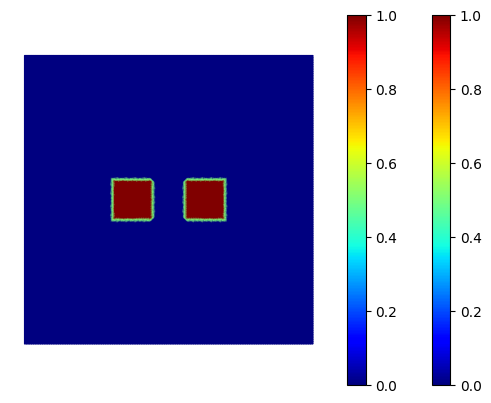

Area is 450
Area Estimate: 569.53125


In [8]:
# Step 1: Define the Geometry of two rectangular islands:

sideLen = 15
centerLeft,centerRight = (15,0), (-15,0)
area = 2 * (sideLen ** 2)

def theta(x_vec):
    x,y = x_vec[0],x_vec[1]
    cond1 = (jnp.abs(x-centerLeft[0]) <= sideLen / 2) & (jnp.abs(y-centerLeft[1]) <= sideLen / 2)
    cond2 = (jnp.abs(x-centerRight[0]) <= sideLen / 2) & (jnp.abs(y-centerRight[1]) <= sideLen / 2)
    return cond1 | cond2

def theta_right_only(x_vec):
    x,y = x_vec[0],x_vec[1]
    cond1 = (jnp.abs(x-centerLeft[0]) <= sideLen / 2) & (jnp.abs(y-centerLeft[1]) <= sideLen / 2)
    cond2 = (jnp.abs(x-centerRight[0]) <= sideLen / 2) & (jnp.abs(y-centerRight[1]) <= sideLen / 2)
    return cond1

femsystem.plot_func_2d(lambda a,b: theta([a,b]))
print(f"Area is {area}")

# Now get integrated area. 
theta_at_dofs = theta(femsystem.doflocs).astype(jnp.float32)
integrated_area = femsystem.integrate(lambda u,grad_u,x: u,theta_at_dofs)
print(f"Area Estimate: {integrated_area}")

In [9]:
G_mat = femsystem.get_greens_kernel()

/scratch/gpfs/AROD/vc9839/finite-island-cqed/jax-gpu/lib64/python3.9/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/scratch/gpfs/AROD/vc9839/finite-island-cqed/jax-gpu/lib64/python3.9/site-packages/scipy/sparse/linalg/_matfuncs.py:76: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  Ainv = spsolve(A, I)


In [10]:
def laplacian(u,grad_u,x):
    return -1*jnp.sum(grad_u**2,axis=0)

# For Potential Energy Double Inetgral, u1 is our function phi_{+/-} and u2 is theta. 
def u_squared(u,grad_u,u2,grad_u2,x):
    return u**2

# Define Pre-Computed Values for Theta and Green's Function:
def theta_func(u,grad_u,u2,grad_u2,x):
    return u2

# U_{++++} or U_{----}, Really N * \alpha
def alpha(u,G_mat,femsystem):
    return integrated_area  * femsystem.double_integral(lambda u1,a,b,c,d: u1**2,lambda u1,a,b,c,d: u1**2,G_mat,u,u)

# U_{+--+} = U{-++-} - Remember middle two are wrt to y, Outer two wrt to x, from notation used in doc
def beta(u1_arg,u2_arg,G_mat):
    return femsystem.double_integral(lambda u1,a,b,c,d: u1**2, lambda a,b,u2,c,d: u2**2, G_mat, u1_arg,u2_arg)

# U_{++--} = U{+-+-}
def gamma(u1_arg,u2_arg,G_mat):
    return femsystem.double_integral(lambda u1,a,u2,c,d: u1*u2, lambda u1,b,u2,c,d: u1*u2, G_mat, u1_arg,u2_arg)


# VERY VERY IMPORTANT TO PASS IN G_mat AS AN ARGUMENT, AND SET TO CONSTANT IN OPTIMIZATION LOOP
# This is because when JAX compiles this function, it will treat the G_mat as a "tracer", so just any matrix of constants with some shape. 
# If you hardcode it into the function, it will treat it as an actual part of the code and will spent time compiling a massive amount of hardcoded values as "code" essentially. This is why it takes almost 10 minutes to run first optimization iteration. 
# @jax.jit


def epsilon_func(u_global,G_mat,femsystem,theta_at_dofs):
    # Kinetic Term
    kinetic = -4 * femsystem.integrate(laplacian,u_global)

    # Potential Term
    potential = -2 * femsystem.double_integral(u_squared,theta_func,G_mat,u_global,theta_at_dofs)

    return kinetic  + potential

def E(u_global,G_mat,femsystem,theta_at_dofs):
    return epsilon_func(u_global,G_mat,femsystem,theta_at_dofs) + alpha(u_global,G_mat,femsystem)

# Objective is E+ - E- / 2
@jax.jit
def objective_with_interactions(u_interior,G_mat,femsystem,theta_at_dofs):
    print(f"TRACING objective... phi_val type: {type(femsystem.phi_val)}")

    u_even,u_odd = femsystem.separate_even_odd_apply_by_and_norm(u_interior)
    E_plus,E_minus = E(u_even,G_mat,femsystem,theta_at_dofs), E(u_odd,G_mat,femsystem,theta_at_dofs)
    return (E_plus + E_minus) / 2


# Test that it doesn't give an error
u_init_interior = femsystem.ones_on_island(theta_right_only)
temp = objective_with_interactions(u_init_interior,G_mat,femsystem,theta_at_dofs)
# print(temp)
# u_even,u_odd = femsystem.separate_even_odd_apply_by_and_norm(u_init_interior)
# # femsystem.plot_at_interior_2d_in3d(u_odd[femsystem.interior_dofs])
# femsystem.plot_at_interior_2d_in3d(u_init_interior)

TRACING objective... phi_val type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>


In [11]:
@jax.jit
def check_dof_map_tracer(femsystem):
    print(f"DEBUG CHECK: dof_map type is {type(femsystem.dof_map)}")
    return 0

check_dof_map_tracer(femsystem)


DEBUG CHECK: dof_map type is <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>


Array(0, dtype=int32, weak_type=True)

In [12]:
import time

# @jax.jit
# def test_gather_vmap(u, dof_map):
#     # Flatten to 1D to remove any 2D structure confusion
#     flat_indices = dof_map.ravel()
#     # vmap forces a loop construct
#     flat_u = jax.vmap(lambda i: u[i])(flat_indices)
#     # Reshape back to (E, L)
#     return flat_u.reshape(dof_map.shape)

# print("Benchmarking Vmap Gather...")
# start = time.time()
# _ = test_gather_vmap(u_init_interior, femsystem.dof_map).block_until_ready()
# print(f"Vmap Gather Compile+Run: {time.time() - start:.4f}s")


# 1. Test Gather (dof_map) compilation
@jax.jit
def test_gather(u, dof_map):
    return jnp.take(u,dof_map)

print("Benchmarking Gather...")
start = time.time()
_ = test_gather(u_init_interior, femsystem.dof_map).block_until_ready()
print(f"Gather Compile+Run: {time.time() - start:.4f}s")

# 2. Test Interpolation Values compilation
@jax.jit
def test_interp_val(u, femsystem):
    return femsystem._interpolate_values(u)

print("Benchmarking Interpolate Values...")
start = time.time()
_ = test_interp_val(u_init_interior, femsystem).block_until_ready()
print(f"Interp Val Compile+Run: {time.time() - start:.4f}s")

# 3. Test Interpolation Grad compilation
@jax.jit
def test_interp_grad(u, femsystem):
    return femsystem._interpolate_grad(u)

print("Benchmarking Interpolate Grad...")
start = time.time()
_ = test_interp_grad(u_init_interior, femsystem).block_until_ready()
print(f"Interp Grad Compile+Run: {time.time() - start:.4f}s")

# 4. Test Integrate compilation
@jax.jit
def test_integrate(u, femsystem):
    return femsystem.integrate(laplacian, u)

print("Benchmarking Integrate...")
start = time.time()
_ = test_integrate(u_init_interior, femsystem).block_until_ready()
print(f"Integrate Compile+Run: {time.time() - start:.4f}s")


Benchmarking Gather...
Gather Compile+Run: 0.0537s
Benchmarking Interpolate Values...
Interp Val Compile+Run: 0.0436s
Benchmarking Interpolate Grad...
Interp Grad Compile+Run: 0.0447s
Benchmarking Integrate...
Integrate Compile+Run: 0.0885s


In [13]:
# Optimization Loop

# Very important to initialize to random instead of all ones, or else odd mode is trivial
# u_init_interior = femsystem.get_initial_random_interior()

print("Starting Optimization")
solver = LBFGS(fun=objective_with_interactions,tol=1e-2,verbose=True)
result = solver.run(u_init_interior,G_mat,femsystem,theta_at_dofs)
result = result.params 
u_interior = result

# u_global = femsystem.apply_bc_and_norm(u_interior)
# int_val = femsystem.integrate(lambda u,grad_u,x: u,u_global**2 * theta_at_dofs)
# data.append([int_str,int_val])

Starting Optimization
TRACING objective... phi_val type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>
INFO: jaxopt.LBFGS: Iter: 1 Gradient Norm (stopping criterion): 0.22749114036560059 Objective Value:-130.79196166992188  Stepsize:1.0  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 2 Gradient Norm (stopping criterion): 0.30021384358406067 Objective Value:-131.0352020263672  Stepsize:1.0  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 3 Gradient Norm (stopping criterion): 0.21830874681472778 Objective Value:-131.06687927246094  Stepsize:0.30048906803131104  Number Linesearch Iterations:2 
INFO: jaxopt.LBFGS: Iter: 4 Gradient Norm (stopping criterion): 0.16790564358234406 Objective Value:-131.08480834960938  Stepsize:0.45073360204696655  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 5 Gradient Norm (stopping criterion): 0.08287160843610764 Objective Value:-131.11273193359375  Stepsize:0.6761003732681274  Number Linesearch Iterations:1

In [14]:
# datanp = jnp.array(data)
# plt.plot(datanp[:,0],datanp[:,1] * integrated_area / area)
# plt.xlabel("Fraction of current Coulomb Interaction Strength (0-1)")
# plt.ylabel("Wavefunction Density within the Geometry")

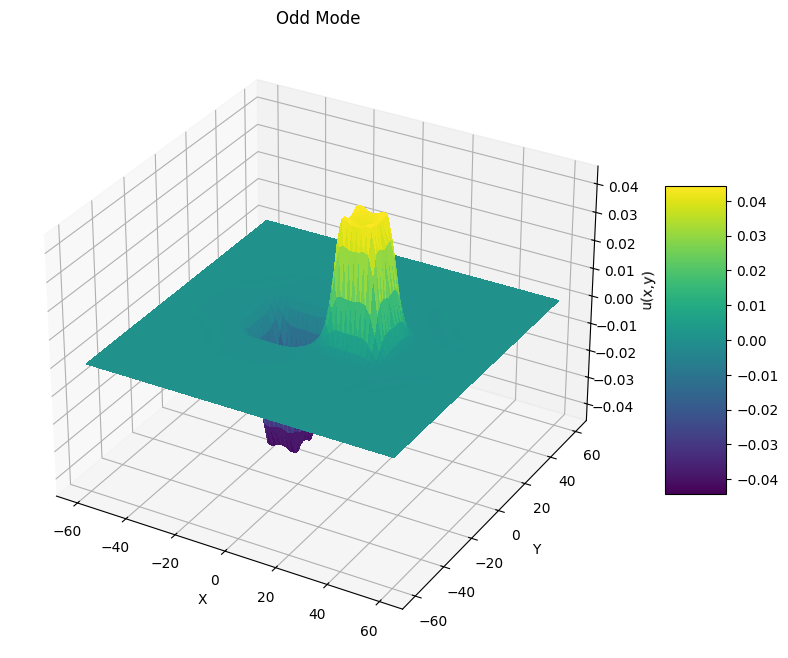

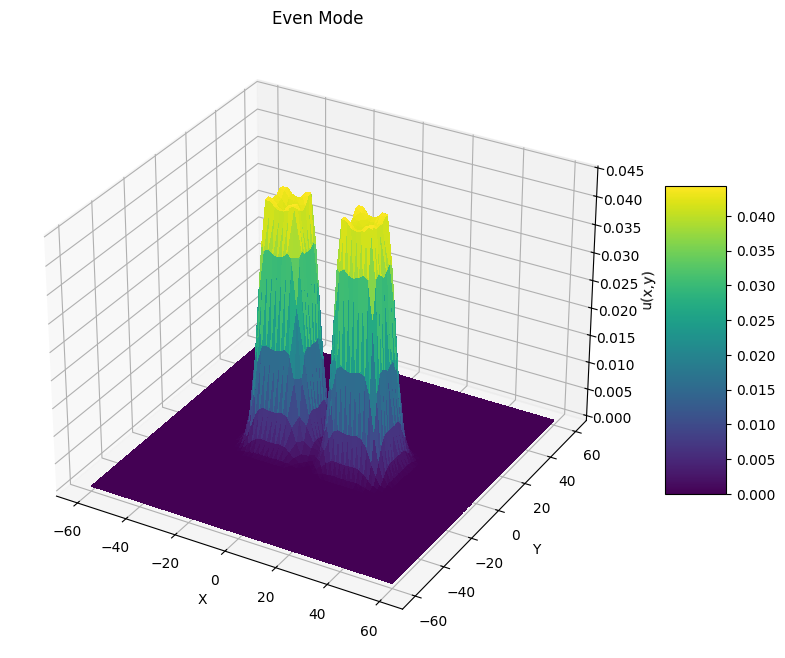

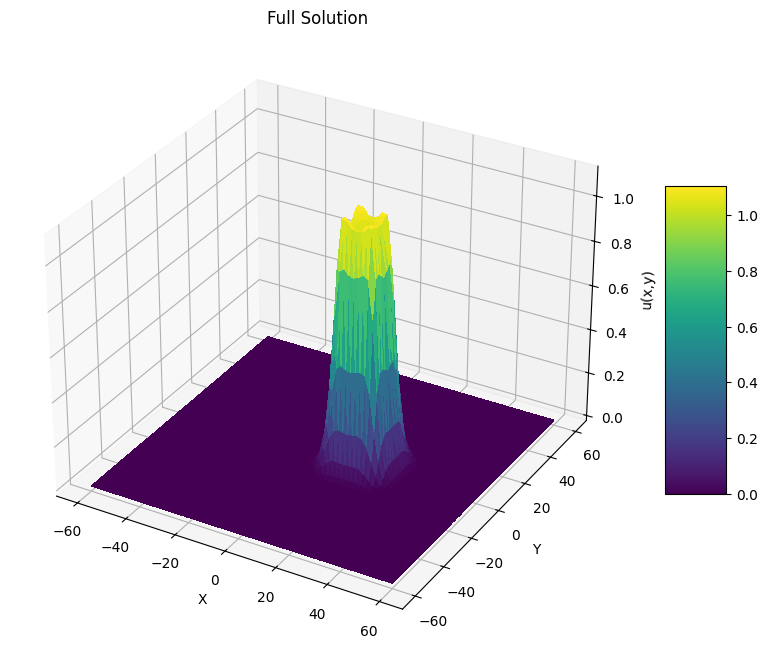

In [15]:
# Get Even and Odd Modes
u_even,u_odd = femsystem.separate_even_odd_apply_by_and_norm(u_interior)
u_even_interior,u_odd_interior = u_even[femsystem.interior_dofs],u_odd[femsystem.interior_dofs]

femsystem.plot_at_interior_2d_in3d(u_odd_interior,plot_title="Odd Mode")
femsystem.plot_at_interior_2d_in3d(u_even_interior,plot_title="Even Mode")
femsystem.plot_at_interior_2d_in3d(u_interior,plot_title="Full Solution")

In [16]:
u_global = femsystem.apply_bc_and_norm(u_interior)
femsystem.integrate(lambda u,grad_u,x: u,u_global**2 * theta_at_dofs)

Array(0.9115111, dtype=float32)